# Process All Data
Get all of the data together. This includes data during formation and aging cycles. Aging cycles include the diagnostic tests as well as the 1C/1C charge/discharge. Summarize the results and plot correlations.

In [3]:
import os

if os.path.basename(os.getcwd()) != 'project-formation':
    os.chdir('..')
    
import numpy as np
import pandas as pd
import glob
import pprint
from datetime import datetime
from scipy.stats import ttest_ind
import seaborn as sns
from matplotlib import pyplot as plt
import re
from src.formation import FormationCell

In [4]:
assert os.path.basename(os.getcwd()) == 'project-formation'

## Configure plot settings

In [5]:
# Configure plot settings
plt.rc('font', **{'family'     : 'sans-serif',
                  'sans-serif' : ['Times New Roman'],
                  'size': 26
                  })
plt.rc('figure', **{'autolayout' : True,
                    'figsize'    : (10, 8)
                    })
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('axes',  labelsize='medium', grid=True)
plt.rc('axes',  titlesize='medium')
plt.rc('legend', fontsize='medium')


DPI = 150
VOLTAGE_LIMITS = (2.95, 4.25)
CAPACITY_LIMITS = (0, 3)

ORANGE = (1, 0.5, 0)
BLUE = (0, 0.5, 1)
BLACK = (0.0, 0.0, 0.0)
GREEN = (0, 0.75, 0)
ORANGE = (1, 0.5, 0)

## Load resources

In [8]:
formation_cells = []
cellid_list = np.arange(1, 41)

for cellid in cellid_list:
    formation_cells.append(FormationCell(cellid))
    
for cell in formation_cells:
    print(cell)

Formation Cell 1
Formation Cell 2
Formation Cell 3
Formation Cell 4
Formation Cell 5
Formation Cell 6
Formation Cell 7
Formation Cell 8
Formation Cell 9
Formation Cell 10
Formation Cell 11
Formation Cell 12
Formation Cell 13
Formation Cell 14
Formation Cell 15
Formation Cell 16
Formation Cell 17
Formation Cell 18
Formation Cell 19
Formation Cell 20
Formation Cell 21
Formation Cell 22
Formation Cell 23
Formation Cell 24
Formation Cell 25
Formation Cell 26
Formation Cell 27
Formation Cell 28
Formation Cell 29
Formation Cell 30
Formation Cell 31
Formation Cell 32
Formation Cell 33
Formation Cell 34
Formation Cell 35
Formation Cell 36
Formation Cell 37
Formation Cell 38
Formation Cell 39
Formation Cell 40


## Plot cycles to x% Retention

In [48]:
# Get the data
results_list = []

for cell in formation_cells:
    
    if cell.cellid == 9:
        continue
        
    stats_dict = cell.get_aging_test_summary_statistics()

    for retention in np.array([80]):

        curr_dict = dict()
        curr_dict['cellid'] = cell.cellid
        curr_dict['is_room_temp'] = cell.is_room_temp()
        curr_dict['formation_type'] = 'Baseline Formation' if cell.is_baseline_formation() else 'Fast Formation'
        curr_dict['retention'] = retention
        curr_dict['cycles'] = stats_dict[f'cycles_to_{retention}_pct']
            
        results_list.append(curr_dict)
        
df = pd.DataFrame(results_list)
df['retention'] = df['retention'].astype('category')


df_room_temp = df[df['is_room_temp'] == 1]
df_high_temp = df[df['is_room_temp'] == 0]

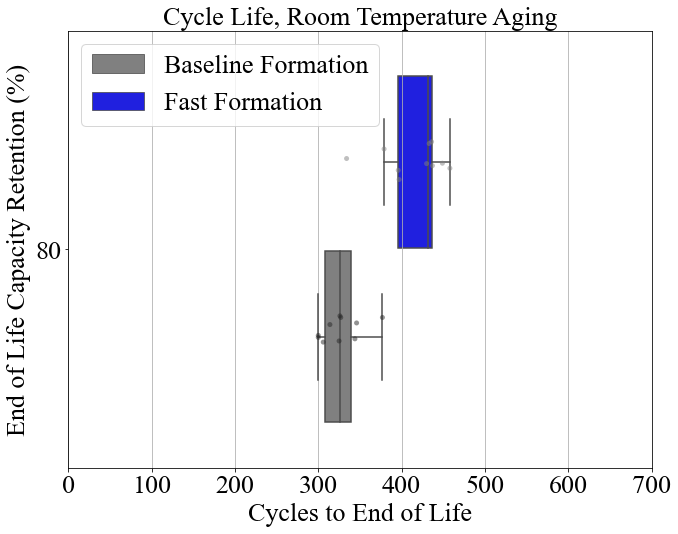

In [49]:
# Make the box plot

bp = sns.boxplot(x='cycles', y='retention',
                 data=df_room_temp,
                 palette=['grey', 'b'],
                 hue='formation_type',
                 showfliers=False
                )

bp = sns.stripplot(x='cycles', y='retention', 
                   data=df_room_temp, 
                   jitter=True,
                   dodge=True, 
                   marker='o', 
                   alpha=0.5,
                   hue='formation_type',
                   color='grey')

bp.set(xlabel='Cycles to End of Life',
       xlim=(0,700),
       ylabel='End of Life Capacity Retention (%)',
       title='Cycle Life, Room Temperature Aging')

bp.invert_yaxis()

handles, labels = bp.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2])

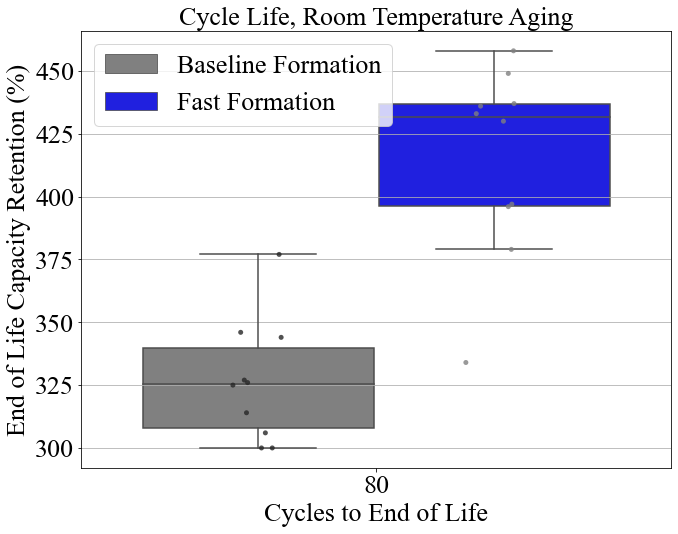

In [54]:
bp = sns.boxplot(x='retention', y='cycles',
                 data=df_room_temp,
                 palette=['grey', 'b'],
                 hue='formation_type',
                 showfliers=False
                )

bp = sns.stripplot(x='retention', y='cycles', 
                   data=df_room_temp, 
                   jitter=True,
                   dodge=True, 
                   marker='o', 
                   alpha=0.8,
                   hue='formation_type',
                   color='grey')

bp.set(xlabel='Cycles to End of Life',
       ylabel='End of Life Capacity Retention (%)',
       title='Cycle Life, Room Temperature Aging')

handles, labels = bp.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2])

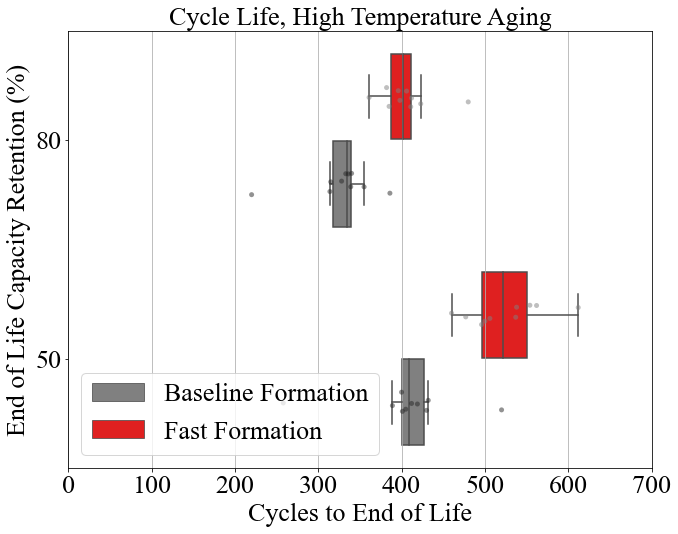

In [21]:
bp = sns.boxplot(x='cycles', y='retention',
                 data=df_high_temp,
                 palette=['grey', 'r'],
                 hue='formation_type',
                 showfliers=False
                )

bp = sns.stripplot(x='cycles', y='retention', 
                   data=df_high_temp, 
                   jitter=True,
                   dodge=True, 
                   marker='o', 
                   alpha=0.5,
                   hue='formation_type',
                   color='grey')

bp.set(xlabel='Cycles to End of Life',
       ylabel='End of Life Capacity Retention (%)',
       xlim=(0,700),
       title='Cycle Life, High Temperature Aging')

bp.invert_yaxis()

handles, labels = bp.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2])

## Compute statistical significance for cycles to x% retention

In [24]:
result = list()

for ret in df.retention.unique():
    
    for is_room_temp in [0, 1]:
        
        df_subset = df[(df['retention'] == ret) & 
                       (df['is_room_temp'] == is_room_temp)]

        set_fast = df_subset[df_subset['formation_type'] == 'Fast Formation']['cycles'].dropna()
        set_baseline = df_subset[df_subset['formation_type'] == 'Baseline Formation']['cycles'].dropna()

        stat, p = ttest_ind(set_fast, set_baseline)

        curr_result = dict()
        curr_result['retention_target'] = ret
        curr_result['p_value'] = p
        curr_result['is_room_temp'] = is_room_temp
        curr_result['temp'] = 'rt' if is_room_temp else 'ht'
        curr_result['stdev_fast'] = np.std(set_fast)
        curr_result['stdev_base'] = np.std(set_baseline)

        result.append(curr_result)

df_result = pd.DataFrame(result)

display(df_result)


,retention_target,p_value,is_room_temp,temp,stdev_fast,stdev_base
0,50,0.000160,0,ht,42.943684,60.584156
1,50,0.000203,1,rt,62.130869,28.650297
2,80,0.000185,0,ht,30.047296,40.566489
3,80,0.000007,1,rt,36.084484,22.848414


In [18]:
df

,cycle_index,dcr_soc_0,dcr_soc_50,dcr_soc_100
0,4,0.051378,0.016627,0.016095
1,57,0.036338,0.018267,0.017384
2,160,0.029553,0.019788,0.019091
3,263,0.030360,0.022015,0.021247
4,366,0.034284,0.025363,0.024528
5,469,0.043197,0.033309,0.031863
6,522,0.043979,0.035478,0.034442


## Process the data from the Diagnostic Cycles

### DC Resistance

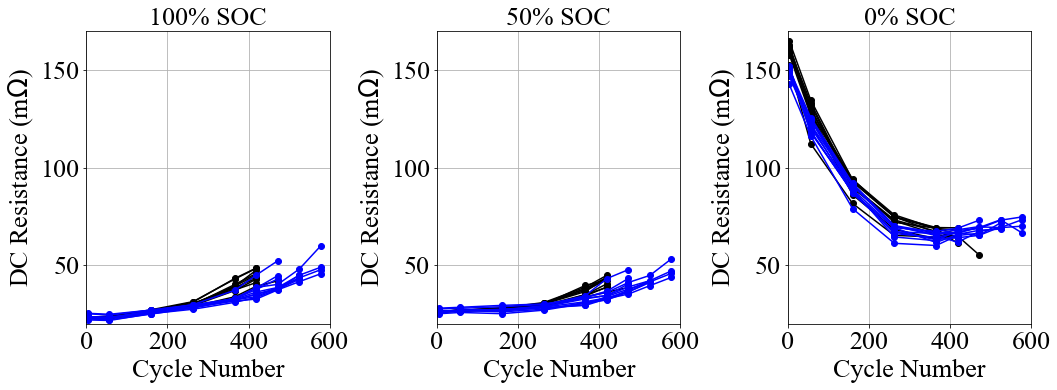

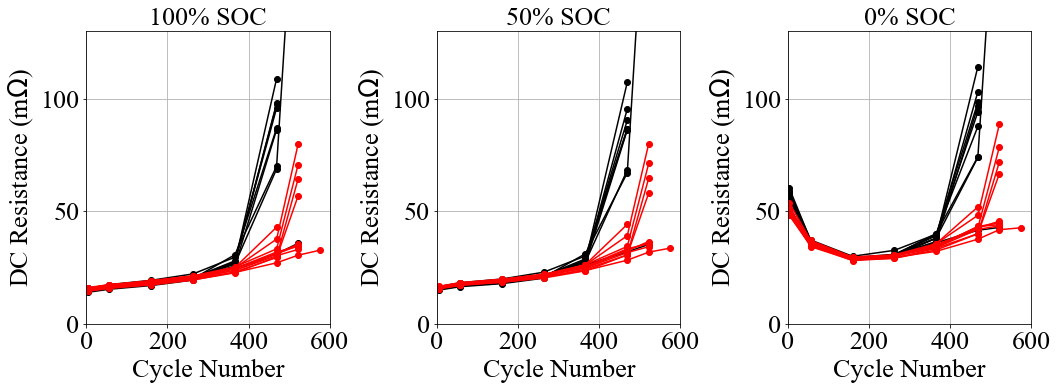

In [42]:
# Room temperature

fig, axs = plt.subplots(1, 3, figsize=(15,6))

for cell in formation_cells:
    
    if cell.cellid == 9:
        continue
        
    if cell.is_room_temp():
        
        df = cell.summarize_hppc_pulse_statistics()
        color = 'k' if cell.is_baseline_formation() else 'b'
        axs[0].plot(df['cycle_index'], df['dcr_soc_100']*1000, color=color, marker='o')
        axs[1].plot(df['cycle_index'], df['dcr_soc_50']*1000, color=color, marker='o')
        axs[2].plot(df['cycle_index'], df['dcr_soc_0']*1000, color=color, marker='o')
            
for ax in axs:
    ax.set(xlabel='Cycle Number', 
           ylabel='DC Resistance (m$\Omega$)', 
           xlim=(0, 600),
           ylim=(20, 170)
          )
    
axs[0].set(title='100% SOC')
axs[1].set(title='50% SOC')
axs[2].set(title='0% SOC')

plt.tight_layout()
plt.show()


# High temperatures
fig, axs = plt.subplots(1, 3, figsize=(15,6))

for cell in formation_cells:
    
    if cell.cellid == 9:
        continue
    
    if not cell.is_room_temp():
        df = cell.summarize_hppc_pulse_statistics()
        color = 'k' if cell.is_baseline_formation() else 'r'
        axs[0].plot(df['cycle_index'], df['dcr_soc_100']*1000, color=color, marker='o')   
        axs[1].plot(df['cycle_index'], df['dcr_soc_50']*1000, color=color, marker='o')
        axs[2].plot(df['cycle_index'], df['dcr_soc_0']*1000, color=color, marker='o')
            
for ax in axs:
    ax.set(xlabel='Cycle Number', 
           ylabel='DC Resistance (m$\Omega$)', 
           xlim=(0, 600),
           ylim=(0, 130)
          )
    
axs[0].set(title='100% SOC')
axs[1].set(title='50% SOC')
axs[2].set(title='0% SOC')

plt.tight_layout()
plt.show()



### C/20 and C/3 discharge capacities

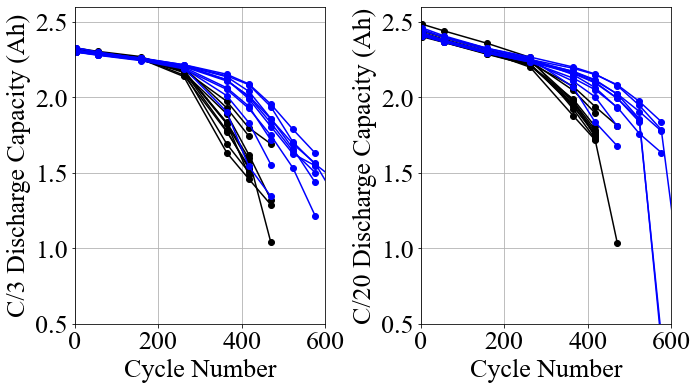

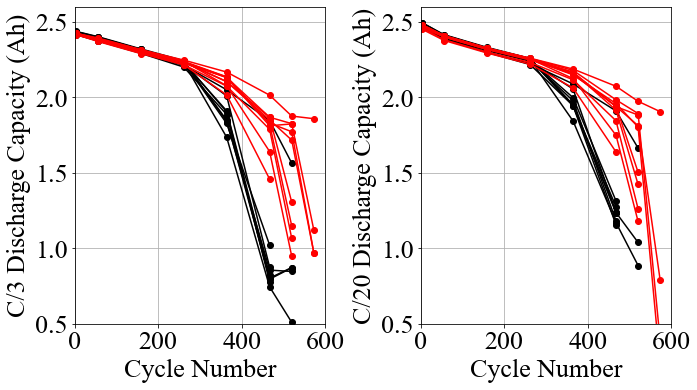

In [45]:
# Room temperature

fig, axs = plt.subplots(1, 2, figsize=(10,6))

for cell in formation_cells:

    if cell.cellid == 9:
        continue
        
    if cell.is_room_temp():
        
        results_c3 = cell.process_diagnostic_c3_data()
        results_c20 = cell.process_diagnostic_c20_data()

        # Unpack the relevant data content for the current cell
        cycle_index_c3 = []
        discharge_capacity_c3 = []
        
        for res in results_c3:
            if not res['dch_capacity'].empty:
                cycle_index_c3.append(res['cycle_index'])
                discharge_capacity_c3.append(res['dch_capacity'].iloc[-1])

        cycle_index_c20 = []
        discharge_capacity_c20 = []
        
        for res in results_c20:
            if not res['dch_capacity'].empty:
                cycle_index_c20.append(res['cycle_index'])
                discharge_capacity_c20.append(res['dch_capacity'].iloc[-1])
                        
        color = (0,0,0) if cell.is_baseline_formation() else (0,0,1)
        axs[0].plot(cycle_index_c3, discharge_capacity_c3, color=color, marker='o')  
        axs[1].plot(cycle_index_c20, discharge_capacity_c20, color=color, marker='o')
        axs[0].set(ylabel='C/3 Discharge Capacity (Ah)')
        axs[1].set(ylabel='C/20 Discharge Capacity (Ah)')
            
for ax in axs:
    ax.set(xlabel='Cycle Number', 
           xlim=(0, 600),
           ylim=(0.5, 2.6)
          )

plt.tight_layout()
plt.show()


# High temperatures
fig, axs = plt.subplots(1, 2, figsize=(10,6))

for cell in formation_cells:
    
    if cell.cellid == 9:
        continue
    
    if not cell.is_room_temp():
                
        results_c3 = cell.process_diagnostic_c3_data()
        results_c20 = cell.process_diagnostic_c20_data()

        # Unpack the relevant data content for the current cell
        cycle_index_c3 = []
        discharge_capacity_c3 = []
        
        for res in results_c3:
            if not res['dch_capacity'].empty:
                cycle_index_c3.append(res['cycle_index'])
                discharge_capacity_c3.append(res['dch_capacity'].iloc[-1])

        cycle_index_c20 = []
        discharge_capacity_c20 = []
        
        for res in results_c20:
            if not res['dch_capacity'].empty:
                cycle_index_c20.append(res['cycle_index'])
                discharge_capacity_c20.append(res['dch_capacity'].iloc[-1])
        
        color = (0,0,0) if cell.is_baseline_formation() else (1,0,0)
        
        axs[0].plot(cycle_index_c3, discharge_capacity_c3, color=color, marker='o')   
        axs[1].plot(cycle_index_c20, discharge_capacity_c20, color=color, marker='o')
        axs[0].set(ylabel='C/3 Discharge Capacity (Ah)')
        axs[1].set(ylabel='C/20 Discharge Capacity (Ah)')
            
for ax in axs:
    ax.set(xlabel='Cycle Number', 
           xlim=(0, 600),
           ylim=(0.5, 2.6)
          )

plt.tight_layout()
plt.show()

## Get the summary statistics for each cell

In [15]:
all_summary_data = []

for cell in formation_cells:
    
    curr_summary = dict()
    
    curr_summary.update(cell.get_formation_test_summary_statistics())
    curr_summary.update(cell.get_aging_test_summary_statistics())
    curr_summary['is_room_temp_aging'] = 1 if cell.is_room_temp() else 0
    curr_summary['is_baseline_formation'] = 1 if cell.is_baseline_formation() else 0
    curr_summary['is_plating'] = 1 if cell.is_plating() else 0
    curr_summary['swelling_severity'] = cell.get_swelling_severity()
    curr_summary['electrolyte_weight_g'] = cell.get_electrolyte_weight()
    curr_summary['form_coulombic_efficiency'] = curr_summary['form_final_discharge_capacity_ah'] / curr_summary['form_first_charge_capacity_ah']
    curr_summary['cellid'] = cell.cellid
    all_summary_data.append(curr_summary)
    
df_corr = pd.DataFrame(all_summary_data)

In [11]:
df_corr.columns

Index(['form_first_charge_capacity_ah', 'form_first_discharge_capacity_ah',
       'form_first_cycle_efficiency', 'form_final_discharge_capacity_ah',
       'form_6hr_rest_voltage_decay_v', 'form_first_cv_hold_capacity_ah',
       'initial_capacity', 'initial_capacity_std', 'cycles_to_50_pct',
       'cycles_to_60_pct', 'cycles_to_70_pct', 'cycles_to_80_pct',
       'initial_cell_dcr_0_soc', 'initial_cell_dcr_50_soc',
       'initial_cell_dcr_100_soc', 'retention_at_c400', 'dcr_0_soc_at_c400',
       'dcr_50_soc_at_c400', 'dcr_100_soc_at_c400', 'is_room_temp_aging',
       'is_baseline_formation', 'is_plating', 'swelling_severity',
       'electrolyte_weight_g', 'form_coulombic_efficiency', 'cellid'],
      dtype='object')

## Make some correlation plots

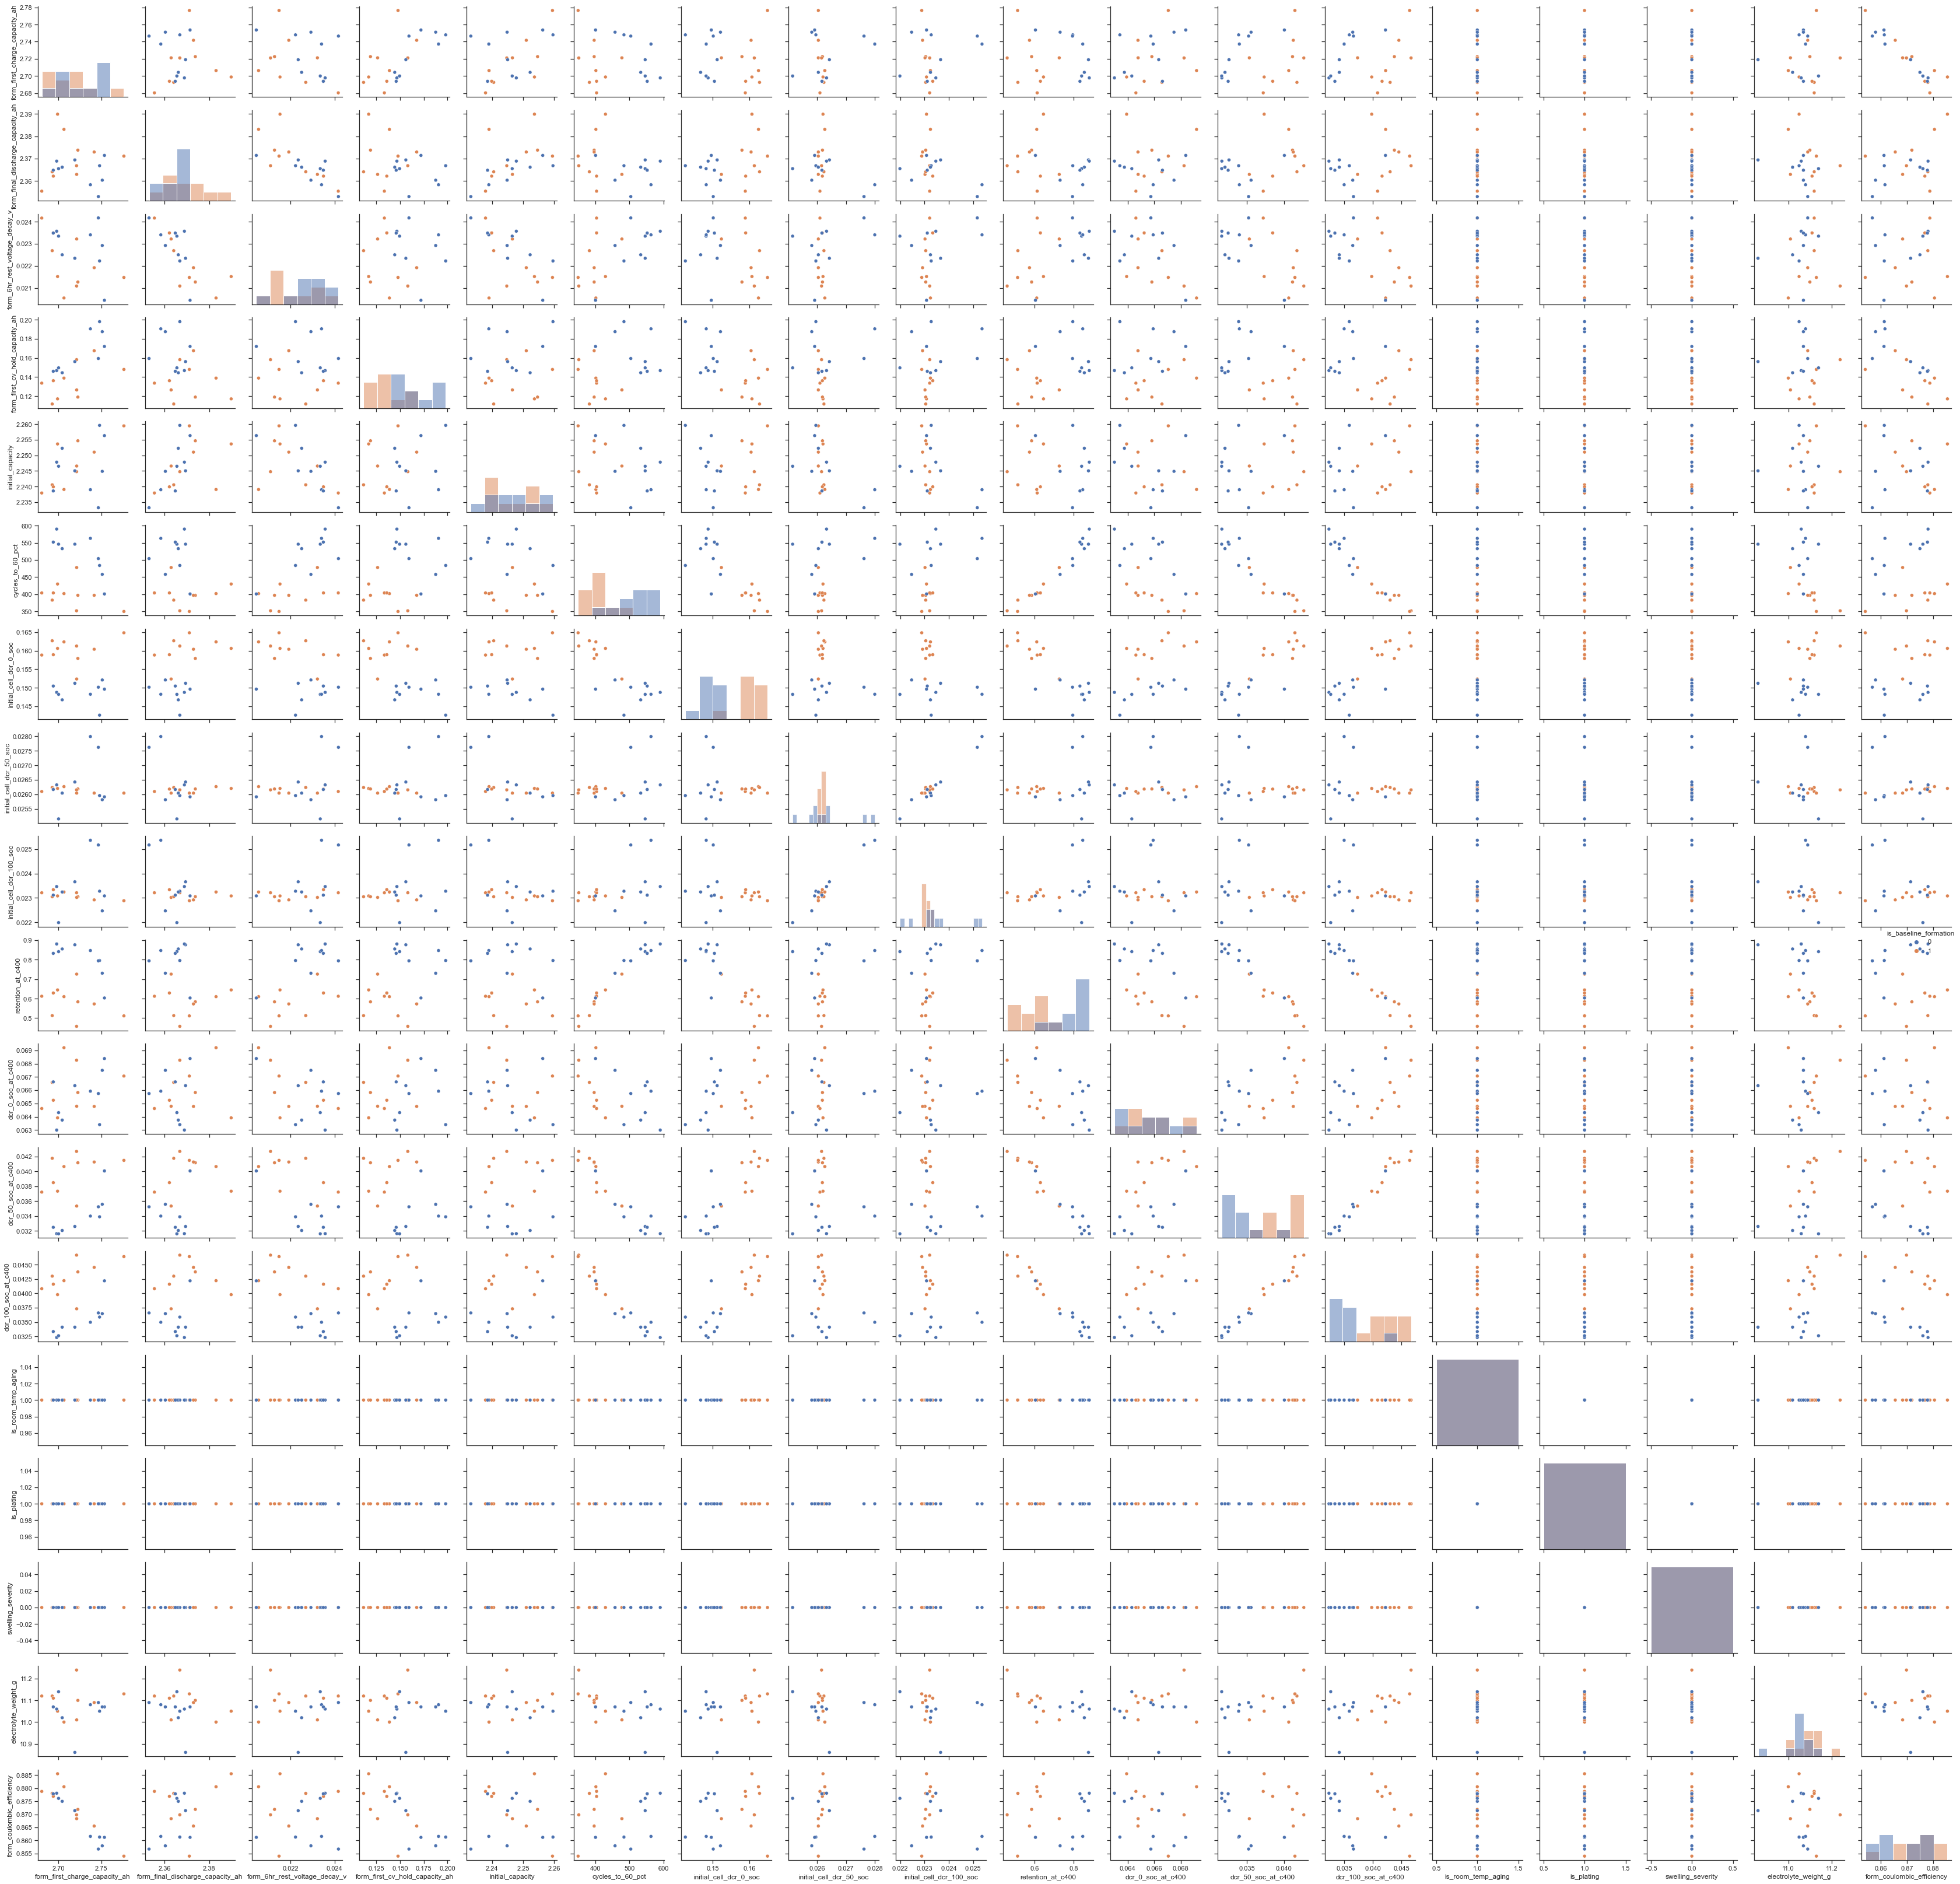

In [12]:
sns.set_theme(style="ticks")

df_plot = df_corr.drop(columns=['initial_capacity_std', 
                                'cycles_to_50_pct', 
                                'cycles_to_70_pct', 
                                'cycles_to_80_pct',
                                'form_first_discharge_capacity_ah',
                                'form_first_cycle_efficiency',
                                'cellid'])

df_plot['swelling_severity'] = df_plot['swelling_severity'].astype(float)

sns_plot = sns.pairplot(df_plot[df_plot['is_room_temp_aging'] == True], 
                        hue='is_baseline_formation',
                        diag_kind='hist')

In [13]:
sns_plot.savefig("output_room_temp.png")

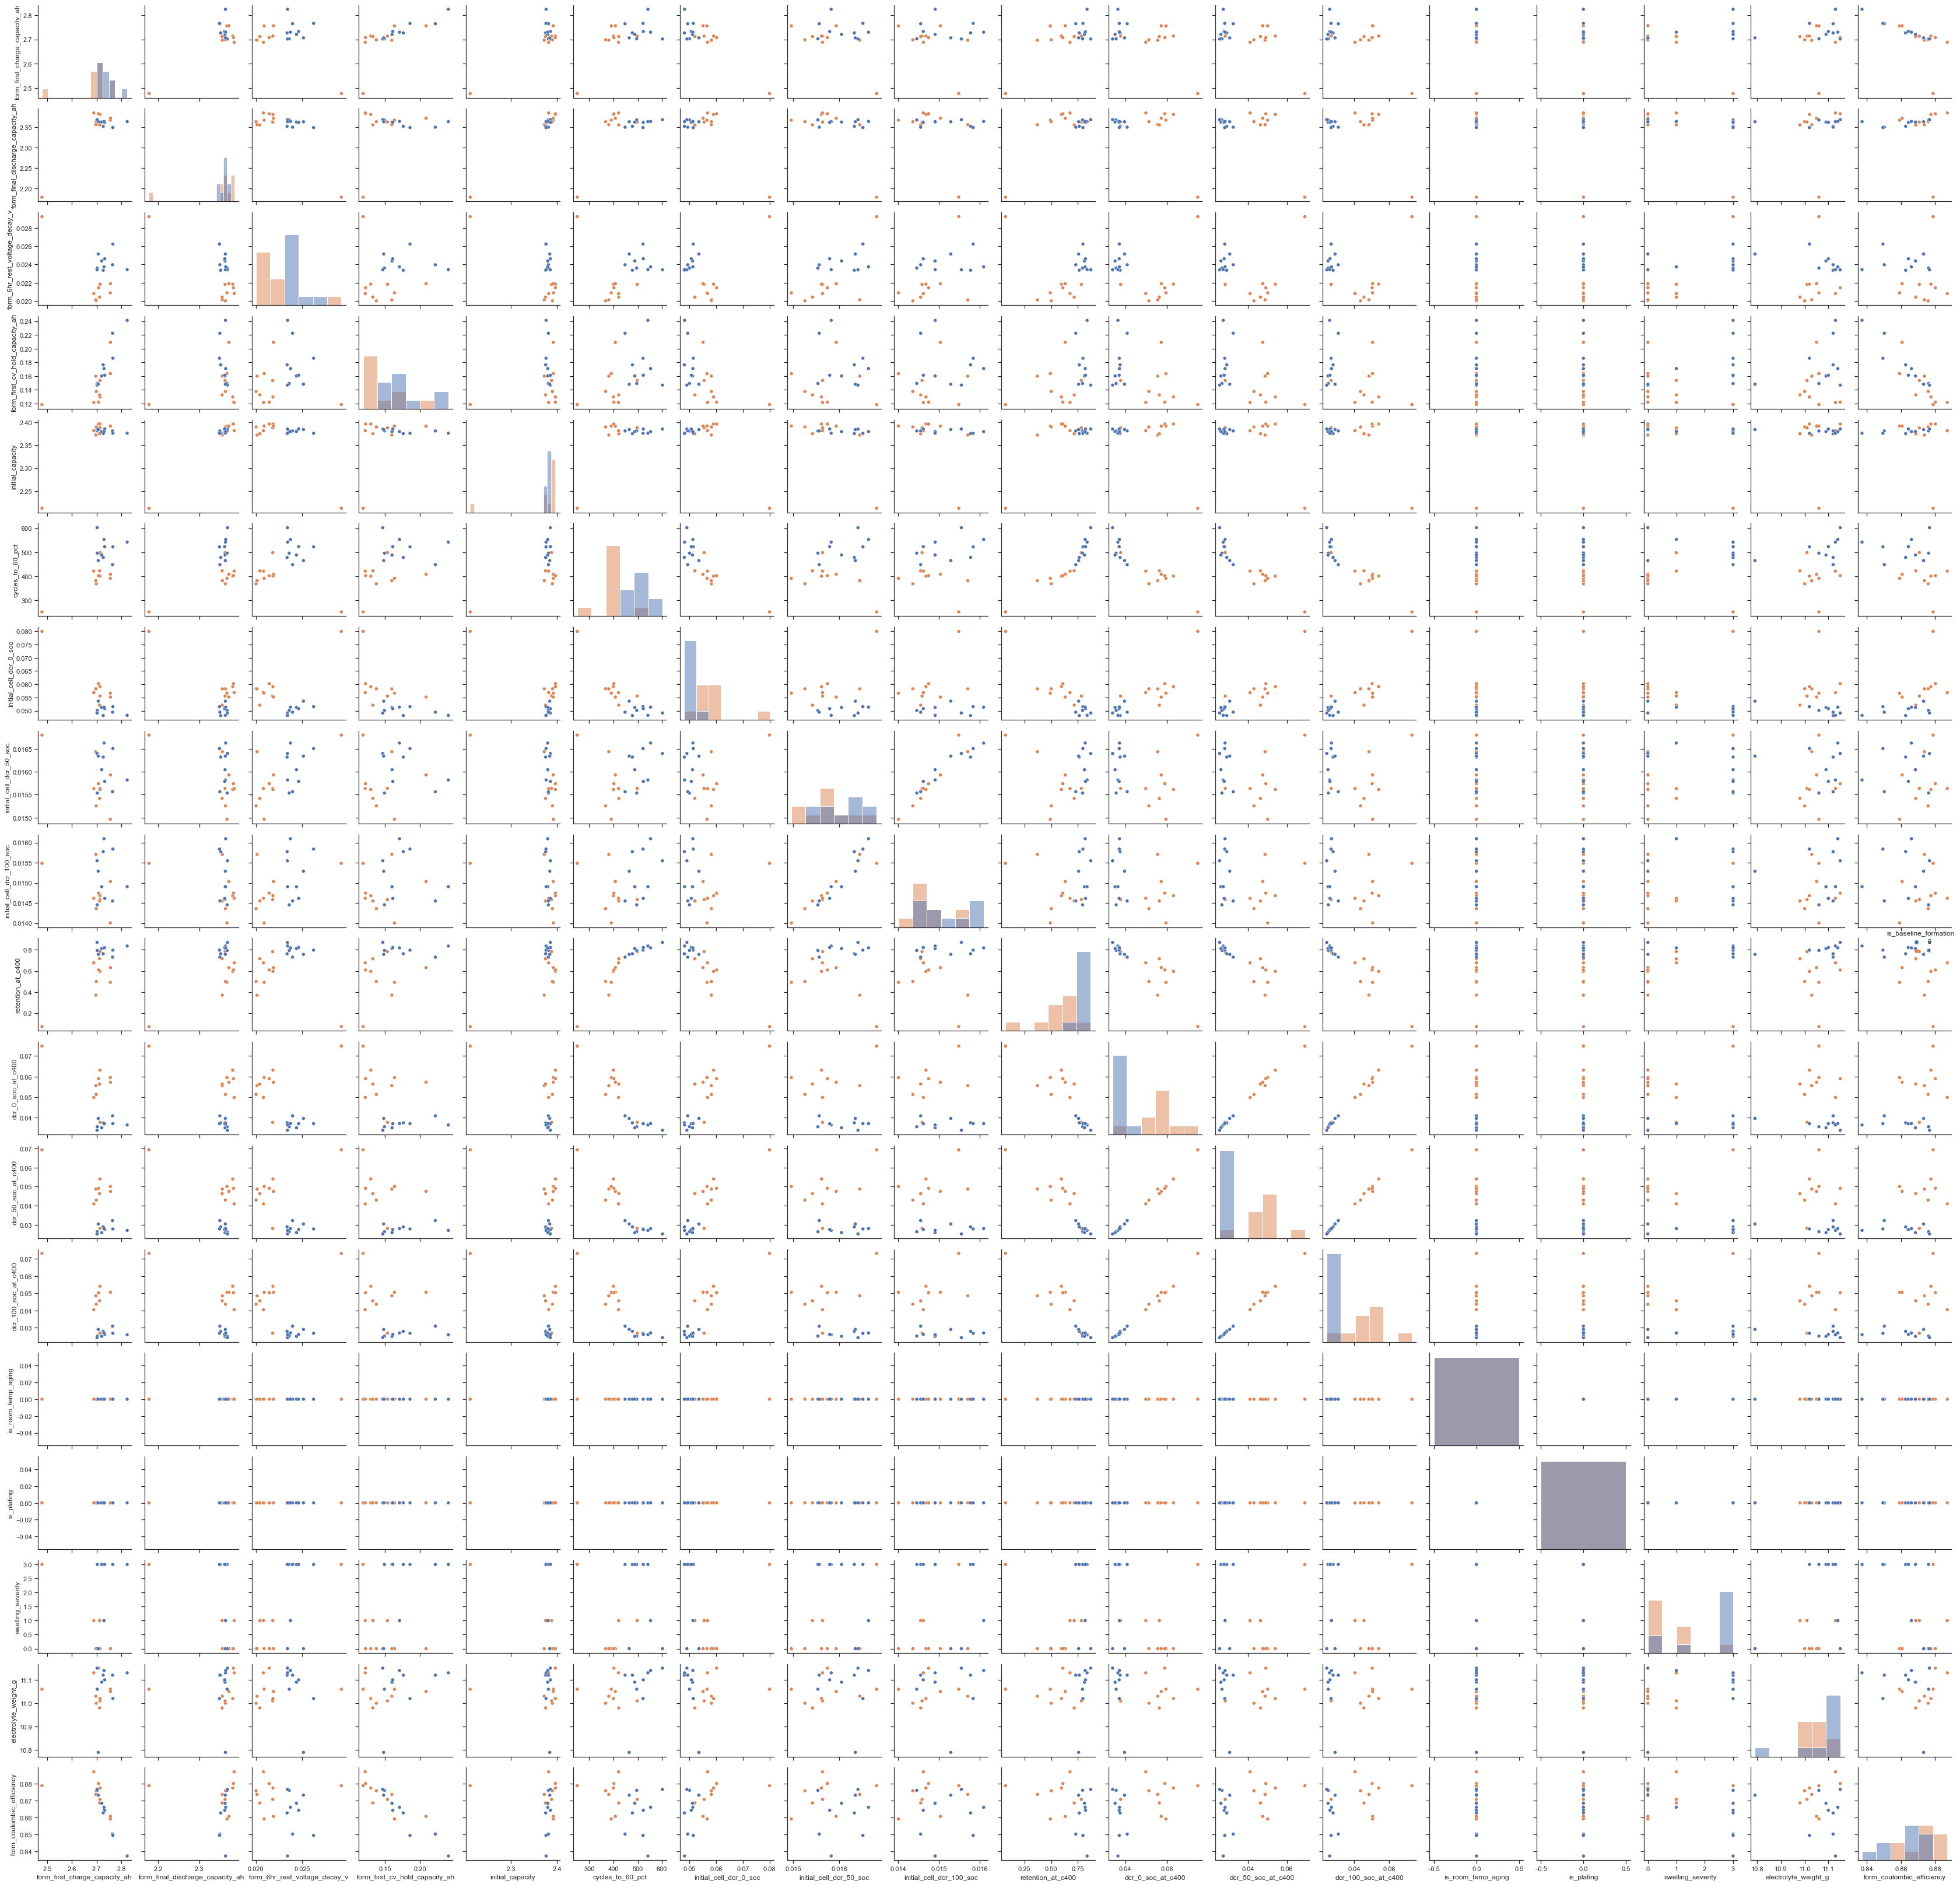

In [14]:
sns_plot = sns.pairplot(df_plot[df_plot['is_room_temp_aging'] == False], 
                        hue='is_baseline_formation',
                        diag_kind='hist')

In [15]:
sns_plot.savefig("output_hot.png")

In [16]:
df_corr.to_csv('correlation_data.csv')

In [17]:
# Drop cell 9 from hereon which is a clear outlier
df_corr = df_corr[df_corr['cellid'] != 9]
df_corr

,form_first_charge_capacity_ah,form_first_discharge_capacity_ah,form_first_cycle_efficiency,form_final_discharge_capacity_ah,form_6hr_rest_voltage_decay_v,form_first_cv_hold_capacity_ah,initial_capacity,initial_capacity_std,cycles_to_50_pct,cycles_to_60_pct,...,dcr_0_soc_at_c400,dcr_50_soc_at_c400,dcr_100_soc_at_c400,is_room_temp_aging,is_baseline_formation,is_plating,swelling_severity,electrolyte_weight_g,form_coulombic_efficiency,cellid
0,2.755302,2.312734,0.839376,2.367225,0.020902,0.163624,2.392219,0.065601,400.0,391,...,0.059503,0.050085,0.050568,0,1,0,0,11.06,0.859153,1
1,2.698299,2.313851,0.857522,2.363418,0.020029,0.137551,2.390043,0.065636,401.0,368,...,0.051329,0.042948,0.043631,0,1,0,0,11.00,0.875892,2
2,2.713403,2.309945,0.851309,2.362668,0.021827,0.153544,2.388198,0.065309,520.0,498,...,0.037796,0.028069,0.026762,0,1,0,1,11.01,0.870740,3
3,2.696613,2.310417,0.856785,2.356018,0.020141,0.159860,2.372319,0.066106,389.0,381,...,0.055565,0.048738,0.048486,0,1,0,0,11.03,0.873695,4
4,2.713639,2.330587,0.858842,2.381257,0.021854,0.129573,2.396523,0.065685,405.0,400,...,0.063102,0.054058,0.054076,0,1,0,0,11.02,0.877514,5
5,2.711829,2.307558,0.850923,2.355594,0.020442,0.132574,2.375177,0.062464,430.0,422,...,0.056354,0.046336,0.045631,0,1,0,1,10.98,0.868637,6
6,2.755931,2.319138,0.841508,2.371946,0.021911,0.209124,2.391926,0.065629,419.0,408,...,0.057250,0.047520,0.050590,0,1,0,0,11.05,0.860670,7
7,2.707419,2.340709,0.864554,2.382960,0.021454,0.122052,2.396469,0.065676,412.0,402,...,0.058974,0.049128,0.050336,0,1,0,0,11.15,0.880159,8
9,2.688354,2.337044,0.869321,2.384860,0.020826,0.121537,2.381898,0.065858,432.0,421,...,0.049862,0.040966,0.040446,0,1,0,1,11.13,0.887108,10
10,2.698795,2.337628,0.866175,2.389859,0.021522,0.117078,2.253642,0.066216,NaN,430,...,0.063916,0.037350,0.039789,1,1,1,0,11.05,0.885528,11


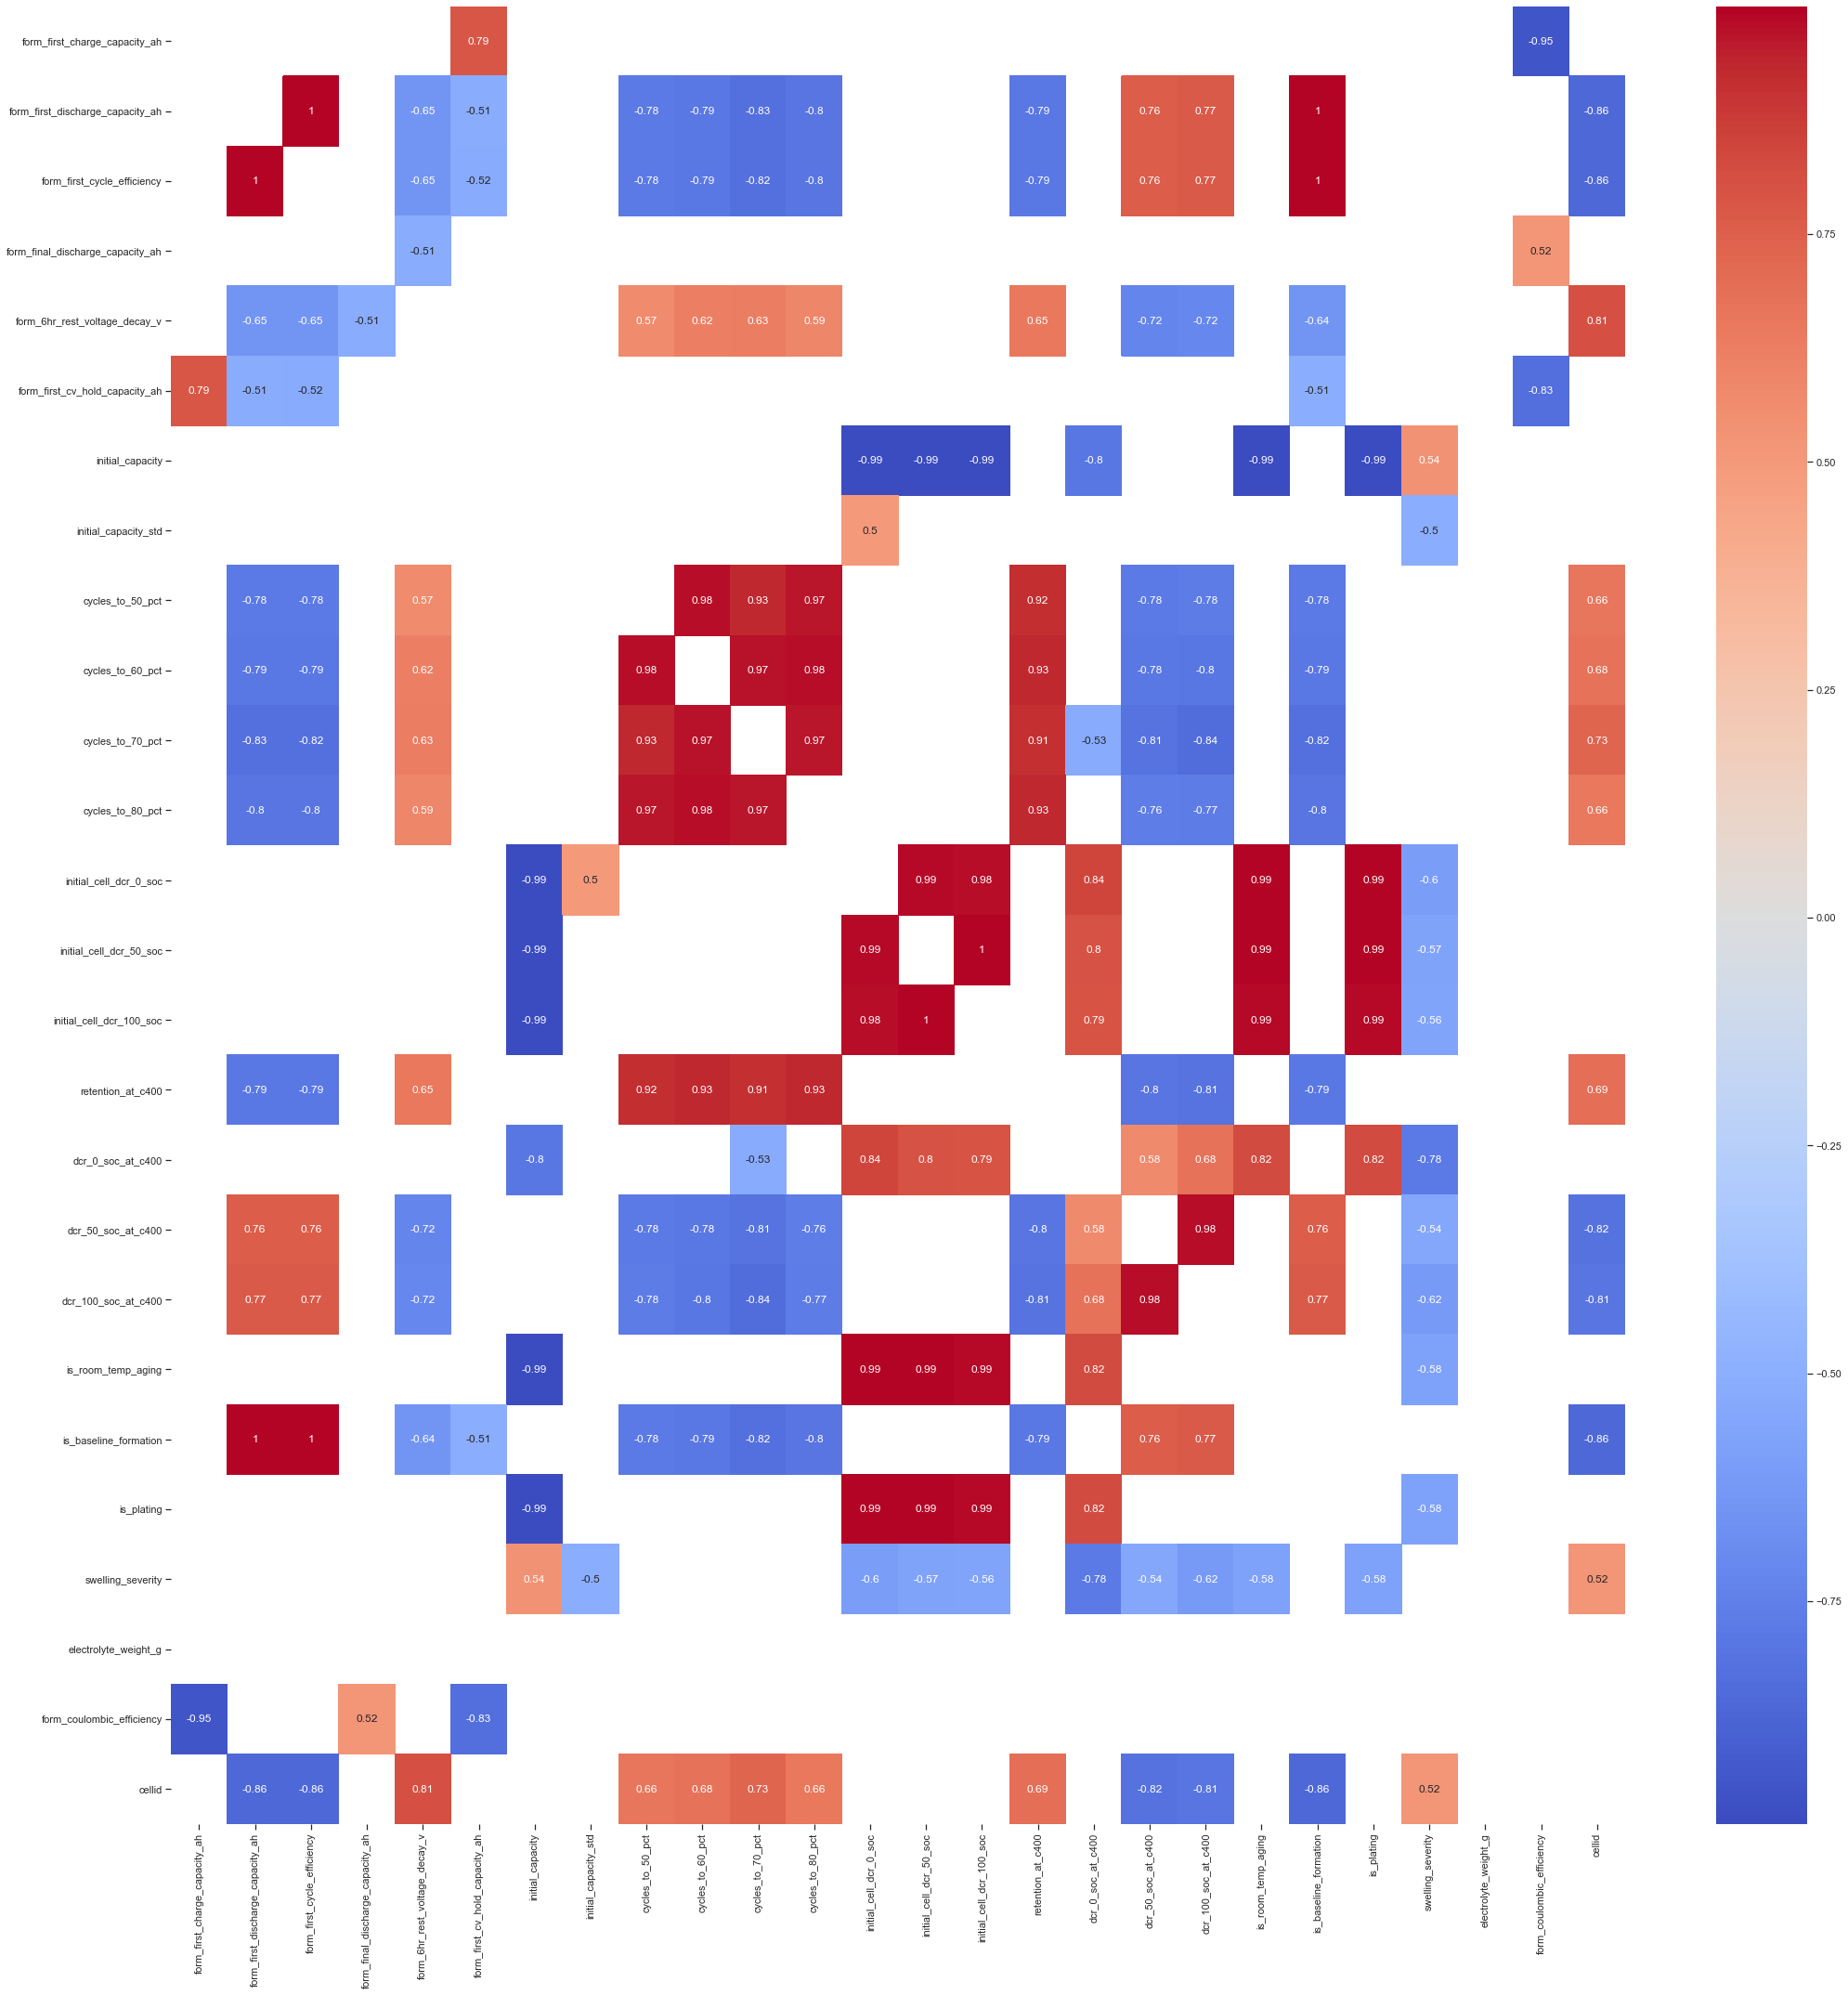

In [18]:
dfCorr = df_corr.corr()
filteredDf = dfCorr[((dfCorr >= .5) | (dfCorr <= -.5)) & (dfCorr !=1.000)]
plt.figure(figsize=(30,30))
sns.heatmap(filteredDf, annot=True, cmap="coolwarm")
plt.savefig('correlation_matrix.png')
plt.show()
